In [1]:
%matplotlib inline

import sys, os, time
from itertools import product

import rasterio as rio
import rasterio.mask as masker
import rasterio.plot as rplt
import rasterio.features
import rasterio.warp
import rasterio.windows as wnd

import fiona
import shapefile as shp
import matplotlib.pyplot as plt
import matplotlib.collections as clt
import numpy as np
import seaborn as sns
from descartes import PolygonPatch

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def plot_shape(shape):
    figsize = (10,6)
    sns.set(style="whitegrid", palette="pastel", color_codes=True)
    sns.mpl.rc("figure", figsize=figsize)
    plt.figure(figsize = figsize)
    x = [i[0] for i in biggest.points]
    y = [i[1] for i in biggest.points]
    plt.plot(x, y, 'k')
    plt.show()
    
def get_full_scene(file):
    with rio.open(file, dtype='float32') as data:
        return data.read().transpose(1, 2, 0).astype(rio.float32), data.meta
    
# returns a partition of a landsat tile
def get_tile(file, width=512, height=512, col_off=0, row_off=0):
    with rio.open(file, dtype='float32') as data:
        meta = data.meta.copy()
        # consider using profile here.
        
        ncols, nrows = meta['width'], meta['height']
        offsets = product(range(0, ncols, width), range(0, nrows, height))
        big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
        window = wnd.Window(col_off=col_off * width, row_off=row_off * height, width=width, height=height).intersection(big_window)
        transform = wnd.transform(window, data.transform)
        
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        return data.read(window=window).transpose(1,2,0).astype(float), meta
    

In [3]:
landsatTileList = r"/home/dsa/DSA/images_manual/scene_list.txt"
landsatDirectory = r"/home/dsa/DSA/images_manual/corrected/LC82201072015017LGN00"
coastMaskShpfile = r"/home/dsa/DSA/vectors/Coastline_high_res_polygon_v7.1.shp"

outputDirectory = r"/home/dsa/DSA/vectors/"
outputFileExt = r"_burjo_output.tif"

assert os.path.isfile(landsatTileList)
assert os.path.isdir(landsatDirectory)
assert os.path.exists(landsatDirectory)
assert os.path.isfile(coastMaskShpfile)
os.listdir(landsatDirectory)

['.fuse_hidden000000a50000001b',
 '.fuse_hidden000000b400000024',
 'LC82201072015017LGN00full_color_seg.tif',
 'LC82201072015017LGN00full_color_seg.tif.aux.xml',
 'LC82201072015017LGN00_B1.TIF',
 'LC82201072015017LGN00_B10.TIF',
 'LC82201072015017LGN00_B11.TIF',
 'LC82201072015017LGN00_B2.TIF',
 'LC82201072015017LGN00_B3.TIF',
 'LC82201072015017LGN00_B4.TIF',
 'LC82201072015017LGN00_B5.TIF',
 'LC82201072015017LGN00_B6.TIF',
 'LC82201072015017LGN00_B7.TIF',
 'LC82201072015017LGN00_burjo_output.tif',
 'LC82201072015017LGN00_burjo_output.tif.aux.xml']

In [4]:
tiles = open(landsatTileList).read().splitlines()

In [5]:
startTime = time.ctime()

In [6]:
print("ArcPy Rock masking script started: %s" % startTime)

ArcPy Rock masking script started: Thu Oct 24 14:12:13 2019


Extracting the main continent polygon from the ADD shapefile.
This is commented out as our test image is landlocked.

In [7]:
for i in range(len(tiles)):
    
    thisTileID = tiles[i]
    thisTileFile = landsatDirectory + "/" + thisTileID
    outFilename = outputDirectory + "/" + thisTileID
    
    fmt = "\t%d of %d."
    print(fmt % (i + 1, len(tiles)))
    tic = time.time()

	1 of 1.


Normally all cells below will be inside the for loop above.
For testing purposes with a single tile they've been removed from the
for block.

Extract bands needed for masks from section with rocks (column and row
offset arbitrarily selected for test partition)

1.6479730606079102


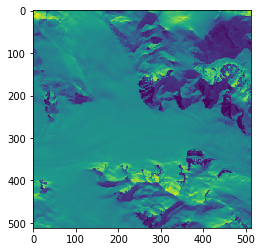

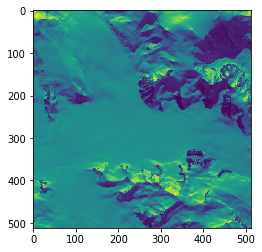

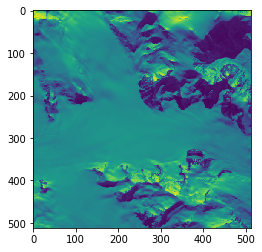

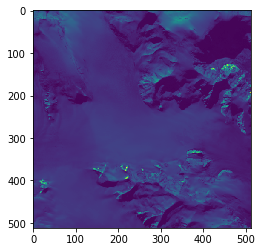

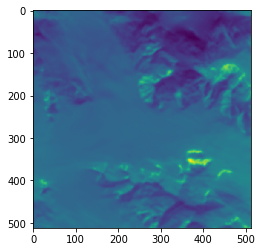

In [60]:
col_off = 12
row_off = 10

B2, B2_meta = get_tile(thisTileFile + "_B2.TIF", col_off=col_off, row_off=row_off)
B2_transform = B2_meta['transform']
print(np.amax(B2))

B3, B3_meta = get_tile(thisTileFile + "_B3.TIF", col_off=col_off, row_off=row_off)

B4, B4_meta = get_tile(thisTileFile + "_B4.TIF", col_off=col_off, row_off=row_off)

B5, B5_meta = get_tile(thisTileFile + "_B5.TIF", col_off=col_off, row_off=row_off)

B6, B6_meta = get_tile(thisTileFile + "_B6.TIF", col_off=col_off, row_off=row_off)

B10, B10_meta = get_tile(thisTileFile + "_B10.TIF", col_off=col_off, row_off=row_off)

# scale temp brightness rasters:
B10 = B10 * .1

rplt.show(B2)
rplt.show(B3)
rplt.show(B5)
rplt.show(B6)
rplt.show(B10)

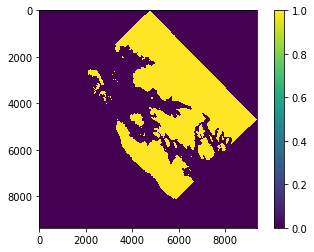

In [27]:
with fiona.open(coastMaskShpfile) as coast_test:
    shapes = [features['geometry'] for features in coast_test]

with rio.open(thisTileFile + "_B2.TIF") as band_test:

    test = (masker.mask(band_test, shapes, crop=True)[0] > 0).astype(rio.uint8)



plt.imshow(test.squeeze())
plt.colorbar()

In [ ]:
poly = biggest.__geo_interface__
ax = plt.gca()
ax.add_patch(PolygonPatch(poly, edgecolor='red', facecolor='none', linewidth=1))
ax.axis('scaled')
rplt.show(B2_whole, transform=B2_whole_transform, ax=ax)

Create normalized versions of bands to display full color image

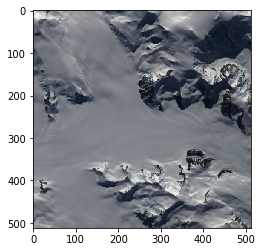

In [61]:
B2_norm = (B2 * (255.0/ B2.max())).astype(int)
B3_norm = (B3 * (255.0/ B3.max())).astype(int)
B4_norm = (B4 * (255.0/ B4.max())).astype(int)
full_color = np.dstack((B4_norm, B3_norm, B2_norm))
plt.imshow(full_color)

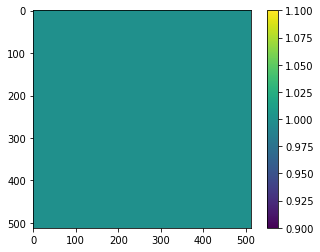

In [62]:
# The example tile is landlocked. skipping coastline mask for now
coastMaskBin = (B2 > 0).astype(int)

plt.imshow(coastMaskBin.squeeze())
plt.colorbar()

In [16]:
toc = time.time()
print(" Loaded & Coast Masked (%.02fs)." % (toc - tic))
tic = time.time()

 Loaded & Coast Masked (810.27s).


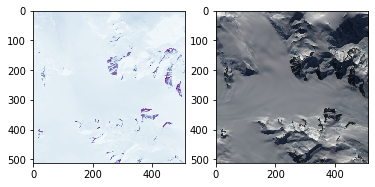

In [63]:
ndsi = (B3 - B6) / (B3 + B6)
fig, axes = plt.subplots(1,2)
im = axes[0].imshow(ndsi.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)

plt.show()

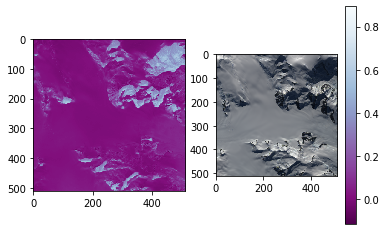

In [64]:
ndwi = (B3 - B5) / (B3 + B5)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(ndwi.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

1720.38828306402 23132.239318072498


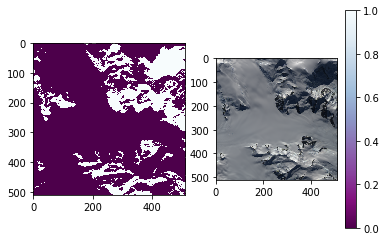

In [65]:
mask1_step1_layer = B10 / B2
mask1_step1 = (mask1_step1_layer > 4000).astype(int)

print(np.amin(mask1_step1_layer), np.amax(mask1_step1_layer))

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_step1.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()


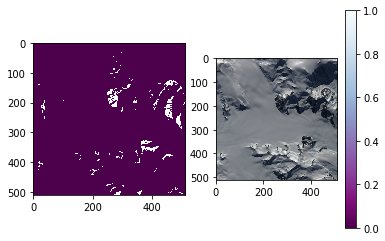

In [66]:
mask1_step2 = (ndsi < 0.70).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_step2.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()


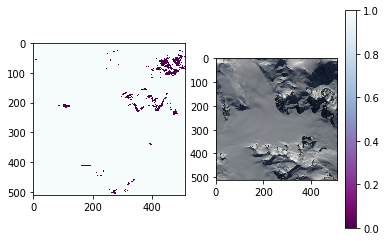

In [67]:
mask1_step3 = (ndwi < 0.45).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_step3.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

2083.7537109375003
4094.6421875


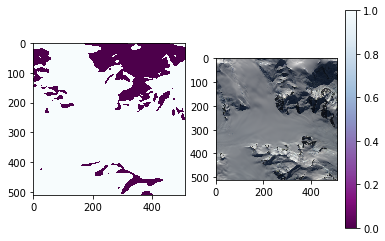

In [68]:
mask1_step5 = (B10 > 2550).astype(int) # Note: this is a scaled value
print(np.amin(B10))
print(np.amax(B10))
fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_step5.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

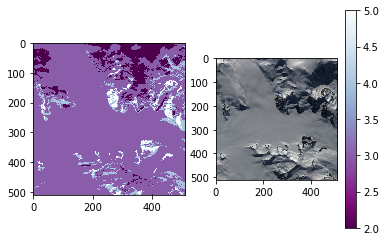

In [69]:
mask1_prefinal = mask1_step1 + mask1_step2 + mask1_step3 + coastMaskBin + mask1_step5

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_prefinal.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

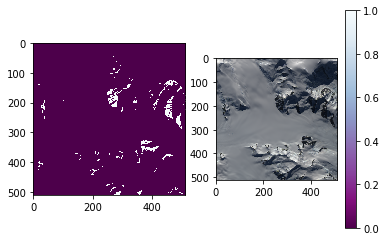

In [70]:
mask1_final = (mask1_prefinal == 5).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask1_final.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

1.6479730606079102


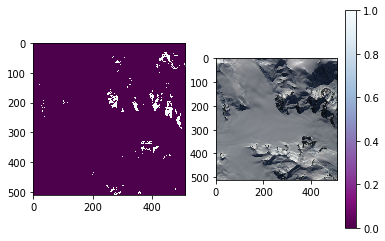

In [71]:
mask2_step1 = (B2 < 0.25).astype(int) # note this is a scaled value
print(np.amax(B2))

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask2_step1.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

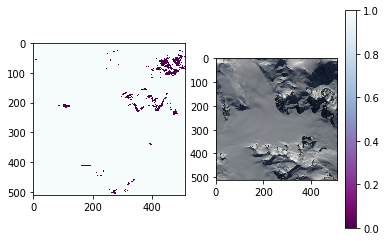

0.8939448066234642


In [72]:
mask2_step2 = (ndwi < 0.45).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask2_step2.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()
print(ndwi.max())

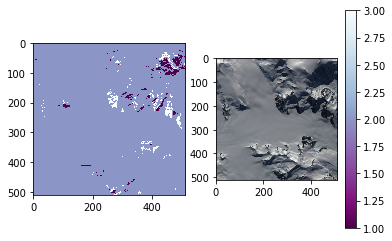

In [73]:
mask2_prefinal = mask2_step1 + mask2_step2 + coastMaskBin

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask2_prefinal.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

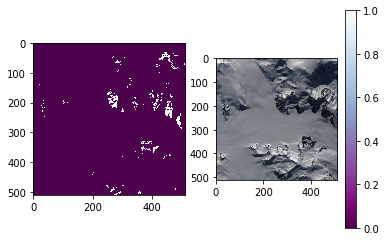

In [74]:
mask2_final = (mask2_prefinal == 3).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask2_final.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

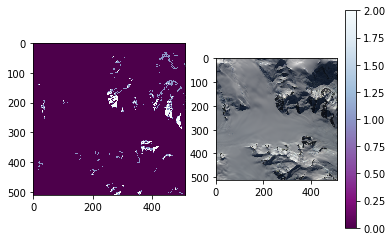

In [75]:
mask_prefinal = mask1_final + mask2_final

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask_prefinal.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

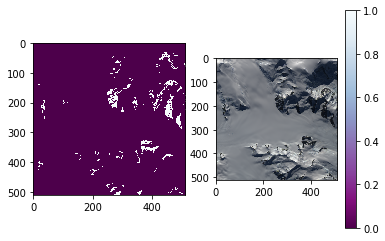

In [76]:
mask_final = (mask_prefinal > 0).astype(int)

fig, axes = plt.subplots(1,2)
im = axes[0].imshow(mask_final.squeeze(), cmap='BuPu_r')
im2 = axes[1].imshow(full_color)
plt.colorbar(im)
plt.show()

## Show RGB image masked to only display pixels IDed as rocks

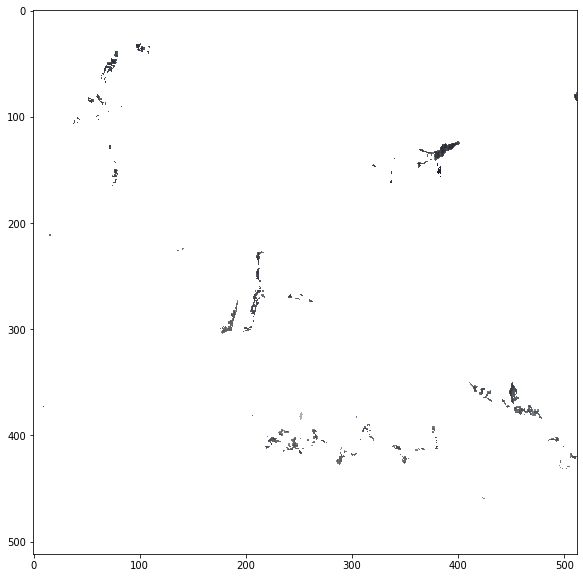

In [29]:
mask_final_norm = mask_final * 255
full_color_masked = np.dstack((B4_norm, B3_norm, B2_norm, mask_final_norm))
plt.imshow(full_color_masked)

## Write the binary raster to file

In [77]:
output_mask = mask_final.transpose(2, 0, 1)
B2_meta['dtype'] = rio.uint16
B2_meta['count'] = 1

with rio.open(landsatDirectory + "/" + thisTileID + outputFileExt, 'w', **B2_meta) as dst:
        dst.write(output_mask.astype(rio.uint16))

In [28]:
full_color_ref = np.dstack((B4_norm, B3_norm, B2_norm)).transpose(2, 0, 1)
color_meta = B2_meta
color_meta['count'] = 3
color_meta['dtype'] = rio.uint16
with rio.open(landsatDirectory + "/" + thisTileID + "full_color_seg.tif", "w", **color_meta) as col_out:
    col_out.write(full_color_ref.astype(rio.uint16))